In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
%config InlineBackend.figure_format = 'retina'

In [2]:
# https://arxiv.org/help/api/user-manual
response = requests.get('https://export.arxiv.org/api/query?search_query=all:GAN&max_results=10000')

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, 'xml')

In [4]:
entries = soup.find_all('entry')
len(entries)

10000

In [5]:
published = (
    pd.to_datetime([entry.published.get_text() for entry in entries])
    .to_series()
    .reset_index(drop=True)
    .rename('published')
)
published_month = (published.round('D') + pd.offsets.MonthBegin(-1)).rename('published_month')
published_year = (published.round('D') + pd.offsets.YearBegin(-1)).rename('published_year')

text = pd.Series([entry.get_text() for entry in entries], name='text')

df = pd.concat([published, text, published_month, published_year], axis=1)
df.head()

,published,text,published_month,published_year
0,2021-11-26 00:45:08+00:00,\nhttp://arxiv.org/abs/2111.13282v1\n2021-11-2...,2021-11-01 00:45:08+00:00,2021-01-01 00:45:08+00:00
1,2019-04-01 12:19:28+00:00,\nhttp://arxiv.org/abs/1904.00724v1\n2019-04-0...,2019-03-01 12:19:28+00:00,2019-01-01 12:19:28+00:00
2,2023-03-27 18:18:15+00:00,\nhttp://arxiv.org/abs/2303.15533v1\n2023-03-2...,2023-03-01 18:18:15+00:00,2023-01-01 18:18:15+00:00
3,2017-01-23 04:46:22+00:00,\nhttp://arxiv.org/abs/1701.06264v6\n2018-03-1...,2017-01-01 04:46:22+00:00,2017-01-01 04:46:22+00:00
4,2020-03-18 05:14:51+00:00,\nhttp://arxiv.org/abs/2003.08047v1\n2020-03-1...,2020-03-01 05:14:51+00:00,2020-01-01 05:14:51+00:00


In [6]:
gan_abstract = (
    df.text.str.contains('GAN') | df.text.str.contains('Generative Adversarial')
)

df_gan = df.loc[gan_abstract]

In [7]:
gan_abstract.mean()

0.679

In [8]:
import datetime as dt
import pandas as pd


In [25]:
import seaborn as sns

published_month_df = (
    df_gan.published_month
    .dt.normalize()
    .value_counts()
    .sort_index()
    .rename('count')
    .cumsum()
    .reset_index()
    .rename(columns={'published_month': 'published'})
)
published_month_df

,published,count
0,2009-02-01 00:00:00+00:00,5
1,2009-03-01 00:00:00+00:00,6
2,2009-12-01 00:00:00+00:00,7
3,2013-12-01 00:00:00+00:00,8
4,2014-12-01 00:00:00+00:00,9
...,...,...
106,2024-06-01 00:00:00+00:00,6575
107,2024-07-01 00:00:00+00:00,6633
108,2024-08-01 00:00:00+00:00,6688
109,2024-09-01 00:00:00+00:00,6758


In [10]:
published_month_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6783 entries, 0 to 6782
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   published  6783 non-null   datetime64[ns, UTC]
 1   count      6783 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(1)
memory usage: 106.1 KB


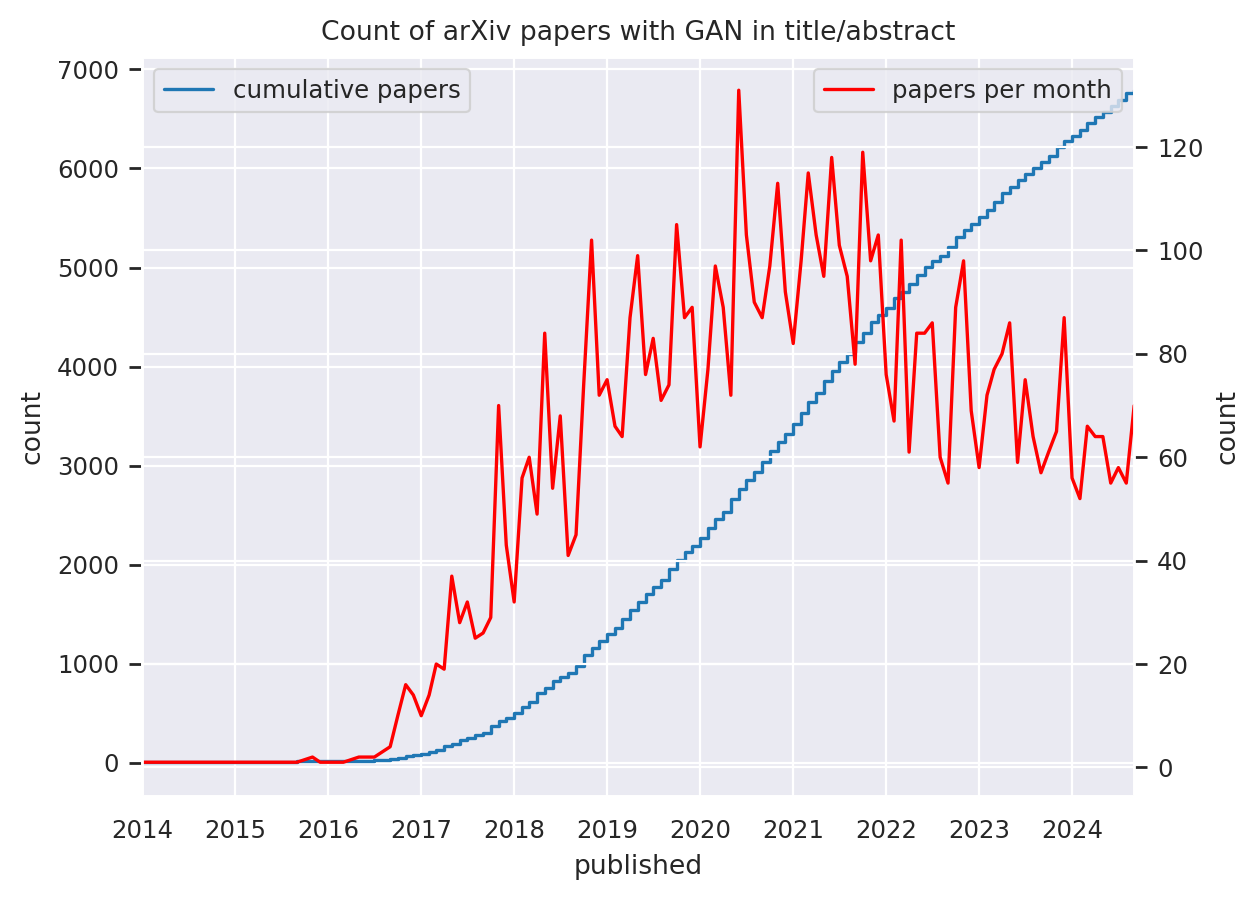

In [34]:
sns.lineplot(data=published_month_df, x='published', y='count', drawstyle='steps', fillstyle='bottom', label='cumulative papers')
sns.lineplot(data=published_month_df.set_index("published").diff().reset_index(), x='published', y='count', ax=plt.gca().twinx(), color='red', label='papers per month')
plt.xlim([dt.date(2014, 1, 1), dt.date(2024, 9, 1)])
plt.title('Count of arXiv papers with GAN in title/abstract')
plt.gca().yaxis.set_major_formatter('{x:,.0f}')
sns.set_context('paper')
sns.set_style('darkgrid')